# <center><div style="font-family: sans-serif; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Imports</div></center>

In [60]:
# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning supplements
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR

# <center><div style="font-family: sans-serif; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Getting train.csv</div></center>

In [61]:
# Importing the training data and parsing the time column as datatime object
raw = pd.read_csv('data/train.csv', parse_dates=['first_day_of_month'])
raw.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


# <center><div style="font-family: sans-serif; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Approach 1 - Minimal Data Manipulation & Basic Modelling</div></center>

# Data Manipulation
1. Feature selection
2. Fill in missing values
3. Convert categorical columns to numerical
4. Splitting data

**IMPORTANT:** We're going to functionize all the data manipulations on the training set so that we can easily replicate them on the test set later on during submission.

In [62]:
# Creating a copy of raw specific to Approach 1
raw_1 = raw.copy()

### 1. Feature Selection
The initial features in the dataset and their importance:
* `row_id` - **redundant**
  * A string combining the `cfips` and `first_day_of_month` features
* `cfips` - **relevant**
  * Integer identifying the county & state from which the `microbusiness_density` is derived
* `county` - **redundant**
  * String identifying the county (not needed because `cfips` already does that)
* `state` - **redundant**
  * String identifying the state (not needed because `cfips` already does that)
* `first_day_of_month` - **relevant**
  * Date object representing when the data was collected
* `microbusiness_density` - **target**
  * microbusinesses per 100 people over the age of 18 in the given county
* `active` - **relevant but unusable currently**
  * The raw count of the microbusinesses in the county
  * However, this is not provided in the test set (we'll need to find out own data for test set and then we can use this on training)

In [63]:
# Converting the date column into separate year and month columns for ease of access
raw_1['year'] = raw_1['first_day_of_month'].dt.year
raw_1['month'] = raw_1['first_day_of_month'].dt.month
raw_1.drop('first_day_of_month', axis=1, inplace=True)

# Removing row_id, county, and state because those are redundant columns
raw_1.drop(['row_id', 'county', 'state'], axis=1, inplace=True)

# Removing active because we cannot currently use it
raw_1.drop('active', axis=1, inplace=True)

In [64]:
raw_1.head()

,cfips,microbusiness_density,year,month
0,1001,3.007682,2019,8
1,1001,2.884870,2019,9
2,1001,3.055843,2019,10
3,1001,2.993233,2019,11
4,1001,2.993233,2019,12


### 2 & 3. Fill in Missing Values & Convert Categorical Columns to Numerical

In [65]:
raw_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cfips                  122265 non-null  int64  
 1   microbusiness_density  122265 non-null  float64
 2   year                   122265 non-null  int64  
 3   month                  122265 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.7 MB


As we can see above, there are <u>no missing values</u>. Additionally, every feature is <u>already numerical</u>.

### 4. Splitting Data

Since we want to build a forecasting model, we cannot merely split the data into a training and testing set randomly. Instead, to evaluate a model on its forecasting ability, we need to <u>train it on the first 80% of the dates</u> (for each county) and <u>validate it on the last 20% of the dates</u> (for each county) that are in our training set.

In [66]:
# Making our training set until Feb 2022 from raw data -- around 80%
training_set = raw_1[raw_1['year'] < 2022].append(raw_1[(raw_1['year'] == 2022) & (raw_1['month'] <= 2)])
X_train = training_set.drop('microbusiness_density', axis=1)
y_train = training_set['microbusiness_density']

# Resetting index for plotting later
X_train.index = np.arange(len(X_train))
y_train.index = np.arange(len(y_train))

# Making our validation set after Feb 2022 to end (Oct 2022) -- around 20%
validation_set = raw_1[(raw_1['year'] == 2022) & (raw_1['month'] > 2)]
X_val = validation_set.drop('microbusiness_density', axis=1)
y_val = validation_set['microbusiness_density']

# Resetting index for plotting later
X_val.index = np.arange(len(X_val))
y_val.index = np.arange(len(y_val))

In [67]:
X_train.tail()

,cfips,year,month
97180,56041,2022,2
97181,56043,2022,1
97182,56043,2022,2
97183,56045,2022,1
97184,56045,2022,2


In [68]:
X_val.head()

,cfips,year,month
0,1001,2022,3
1,1001,2022,4
2,1001,2022,5
3,1001,2022,6
4,1001,2022,7


In [69]:
print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nX_val shape: {X_val.shape}\ny_val shape: {y_val.shape}\n')

train_percent = len(y_train) / len(raw_1)
val_percent = len(y_val) / len(raw_1)
print(f'Train Ratio: {train_percent:.2f}')
print(f'Validation Ratio: {val_percent:.2f}')

X_train shape: (97185, 3)
y_train shape: (97185,)
X_val shape: (25080, 3)
y_val shape: (25080,)

Train Ratio: 0.79
Validation Ratio: 0.21


# Training

We are going to be comparing several different models against each other for this problem. To make this more efficient, we have stored all the models in a dictionary so we can train them together and plot their results alongside each other.

In [70]:
model_dict = {'LinearRegression': LinearRegression(),
              'RandomForestRegressor': RandomForestRegressor(), 
              'XGBoostRegressor': xgb.XGBRegressor()}

In [71]:
def training(model_dict, X_train, y_train):
  '''
  Trains all the models in `model_dict` on `X_train` and `y_train` and returns
  a dictionary of the {model's names: trained models}.
  '''
  for model_name, model_list in model_dict.items():
    print(f'Training {model_name}...')
    model_list.fit(X_train, y_train)
  
  return model_dict

In [72]:
trained_model_dict = training(model_dict, X_train, y_train)

Training LinearRegression...
Training RandomForestRegressor...
Training XGBoostRegressor...


In [73]:
trained_model_dict

{'LinearRegression': LinearRegression(),
 'RandomForestRegressor': RandomForestRegressor(),
 'XGBoostRegressor': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)}

# Evaluation

$$SMAPE = \frac{1}{n} * \sum^{n}_{i=1}{\frac{2 * |P_i - A_i|}{(|A_i| + |P_i|)}}$$ 
where $P$ = predicted value and $A$ = actual value


In [74]:
def SMAPE(actual, pred):
  '''
  Calculates and returns the SMAPE (Symmetrics Mean Absolute Percentage Error) evaluation 
  metric based on the actual values (`actual`) and predicted values (`pred`).
  '''
  numerator = np.abs(pred - actual) * 2
  denominator = np.abs(actual) + np.abs(pred)
  return np.mean(numerator / denominator)

In [75]:
def model_evaluation(trained_model_dict, X_val, y_val, cfip):
  '''
  Finds the SMAPE evaluation metric for each model in `trained_model_dict` using
  `X_val` and `y_val`.
  
  Plots the different SMAPE evaluation metrics for each model in `trained_model_dict`.
  
  Plots the forecasted values for each model and for the given `cfip` code, comparing them to `y_val` (actual values).
  '''
  smape_scores = []
  fig1, ax1 = plt.subplots(1, 2, figsize=(22, 7))
  fig2, ax2 = plt.subplots(1, len(trained_model_dict), figsize=(22, 4))
  color_scheme = ['orange', 'green', 'red', 'pink']
  i = 0
  
  for model_name, trained_model in trained_model_dict.items():
    # Calculating train SMAPE metric
    train_preds = trained_model.predict(X_train)
    train_smape = SMAPE(y_train, train_preds)
    
    # Calculating validation SMAPE metric
    preds = trained_model.predict(X_val)
    val_smape = SMAPE(y_val, preds)
    
    # Appending validation SMAPE to plot it later on
    smape_scores.append(val_smape)
    
    # Documenting Metrics
    print(f'{model_name} (Validation SMAPE): {val_smape * 100:.2f}%')
    print(f'{model_name} (Training SMAPE): {train_smape * 100:.2f}%')
    print('--------------------------------------------------------')
    
    # Plotting main lineplot
    all_dates = raw_1[raw_1['cfips'] == cfip]['month'].astype(str) + '-' + raw_1[raw_1['cfips'] == cfip]['year'].astype(str)
    validation_dates = X_val[X_val['cfips'] == cfip]['month'].astype(str) + '-' + X_val[X_val['cfips'] == cfip]['year'].astype(str)
    
    if (i == 0): ax1[1].plot(all_dates, raw_1[raw_1['cfips'] == cfip]['microbusiness_density'], label='Actual Values')
    ax1[1].plot(validation_dates, preds[X_val[X_val['cfips'] == cfip].index], label=f'{model_name} Predictions', color=color_scheme[i])

    # Plotting  supportive lineplots
    ax2[i].plot(validation_dates, y_val[X_val[X_val['cfips'] == cfip].index], label='Actual Values')
    ax2[i].plot(validation_dates, preds[X_val[X_val['cfips'] == cfip].index], label=f'{model_name} Predictions', color=color_scheme[i])
    i += 1
  
  # Plotting Barplot
  ax1[0].bar(trained_model_dict.keys(), smape_scores, color=color_scheme)
  
  # Main Plot Customizations  
  ax1[1].legend()
  ax1[0].set_ylabel('SMAPE (%)')  
  ax1[1].set_ylabel('Microbusiness Density')
  ax1[1].tick_params(axis='x', labelrotation=45)
  ax1[1].set_title(f'CFIP: {cfip}')
  ax1[1].grid(True)
  
  # Supporting Plot Customizations
  ax2[0].set_ylabel('Microbusiness Density')
  ax2[1].set_title(f'CFIP: {cfip}')
  for i in range(len(trained_model_dict)):
    ax2[i].tick_params(axis='x', labelrotation=45)
    ax2[i].grid(True)
    ax2[i].legend()
      
  plt.show()

LinearRegression (Validation SMAPE): 62.20%
LinearRegression (Training SMAPE): 62.27%
--------------------------------------------------------
RandomForestRegressor (Validation SMAPE): 4.68%
RandomForestRegressor (Training SMAPE): 0.90%
--------------------------------------------------------
XGBoostRegressor (Validation SMAPE): 35.79%
XGBoostRegressor (Training SMAPE): 35.79%
--------------------------------------------------------


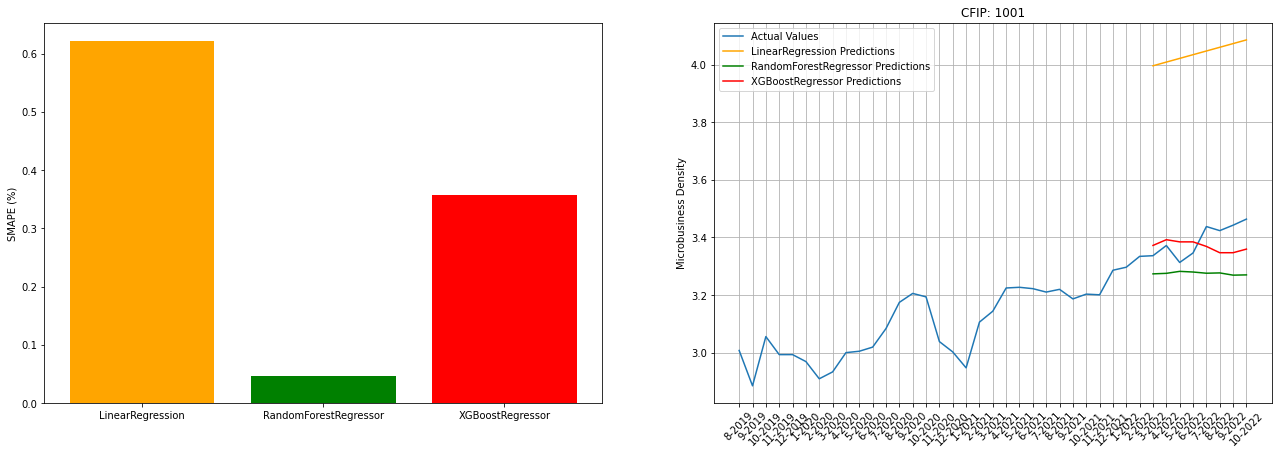

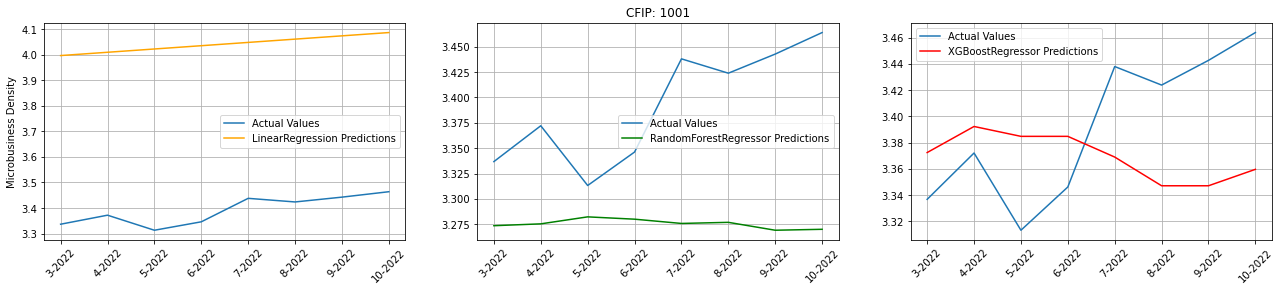

In [76]:
model_evaluation(trained_model_dict, X_val, y_val, 1001)

# Feature Importance

1. Train best model on all the data
2. Graph feature importance

### 1. Train Best Model on all Data

In [77]:
rf = RandomForestRegressor()
rf.fit(raw_1.drop(['microbusiness_density'], axis=1), raw_1['microbusiness_density'])

RandomForestRegressor()

### 2. Graphing Feature Importance

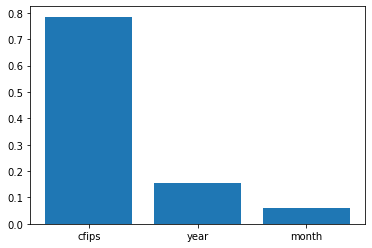

In [78]:
feature_importance = rf.feature_importances_
plt.bar(np.array(X_train.columns), feature_importance);

# Submission

1. Train best model on all data
2. Date manipulation on test set
3. Generate predictions on test set
4. Create final submission dataframe

### 1. Train Best Model on All Data (Already Done)

In [87]:
rf_submission_1 = rf

### Data Manipulation on Test Set

In [88]:
test = pd.read_csv('data/test.csv', parse_dates=['first_day_of_month'])
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [89]:
# Separate first_day_of_month
test['year'] = test['first_day_of_month'].dt.year
test['month'] = test['first_day_of_month'].dt.month

# Saving row_id for making submission dataframe
test_row_id = test['row_id']

# Remove row_id
test.drop(['row_id', 'first_day_of_month'], axis=1, inplace=True)

In [90]:
test.head()

,cfips,year,month
0,1001,2022,11
1,1003,2022,11
2,1005,2022,11
3,1007,2022,11
4,1009,2022,11


### Getting Predictions on Test Set

In [91]:
submission_preds = rf_submission_1.predict(test)

In [92]:
len(submission_preds), len(test_row_id)

(25080, 25080)

### Making Submission DataFrame

In [93]:
submission = pd.DataFrame({'row_id': test_row_id, 
              'microbusiness_density': submission_preds})
submission.head()

,row_id,microbusiness_density
0,1001_2022-11-01,3.452537
1,1003_2022-11-01,8.353497
2,1005_2022-11-01,1.225860
3,1007_2022-11-01,1.273810
4,1009_2022-11-01,1.833923


In [94]:
submission.to_csv('data/first_basic_submission.csv', index=False)

# Score: 1.703

# Future Steps

* It is to be noted that Random Forest is doing quite well on the data
* ❌ Separate the cfip ID for the state & the county into separate columns and see if that improves the model ❌
* Need to combine census data and the training set
* May want to use models like SARIMA and ARIMA or SVM which are good for forecast modeling
* Above, we removed the `active` column from the training set but it helped the model a lot when we trained on it, so try to get that data for test set
* Need to combine loads of data found <a href='https://www.godaddy.com/ventureforward/microbusiness-datahub/'>here</a> with training set
* Need to do hypertuning after getting all the data together
* Could also try to train multiple small models for each county

**IMPORTANT:** The census data has a 2-year lag. This means that the 2017 data in the census dataset actually correlates to the 2019 data in the train dataset.

# Adding Census Data to Train Dataset